### Build an CNN for ECG Signal Classification (5 classes)  - Keras

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd

In [32]:
from google.colab import files

uploaded = files.upload()

Saving ECG_dataX.csv to ECG_dataX (1).csv
Saving ECG_dataY.csv to ECG_dataY (1).csv


### Load the data

In [33]:
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [34]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [35]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [36]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

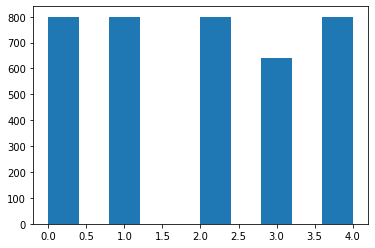

In [37]:
plt.hist(Y)

In [38]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints

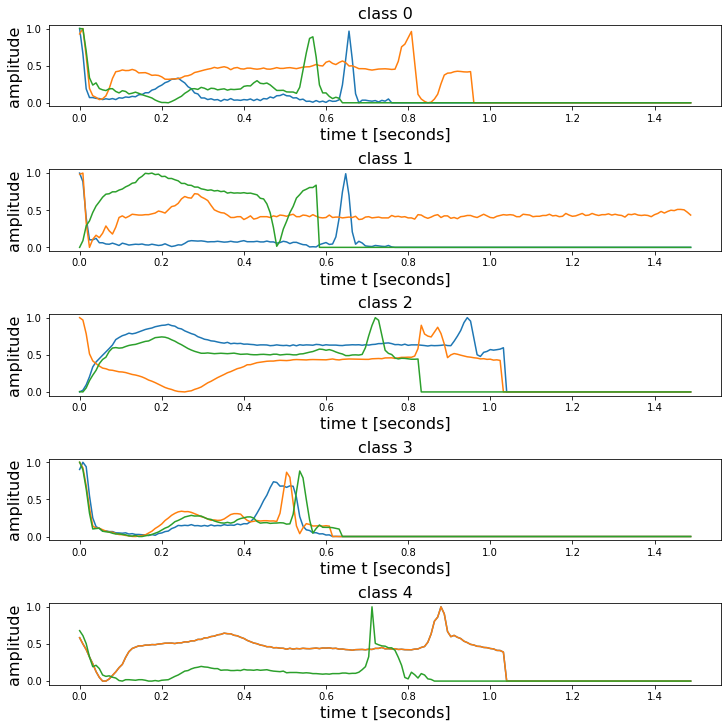

In [40]:
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
#note: add a channel axis to the data if the network is CNN: see the examples presented in class

In [42]:
X_train.shape

(2764, 187)

In [43]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_val=X_val.reshape(X_val.shape[0], X_val.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [44]:
X_train.shape

(2764, 187, 1)

### CNN model

In [46]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras.layers import AveragePooling1D, Conv1D, Flatten
import keras.layers.normalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adamax


inputs = Input(shape=(187,1))
Conv1=Conv1D(filters=32, kernel_size=5, strides=2, padding='valid')(inputs)
Relu1 = Activation("relu")(Conv1)

Conv2 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(Relu1)
Relu2 = Activation("relu")(Conv2)
Avg1 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(Relu1)
S2 = Add()([Relu2, Avg1])

Norm3 = BatchNormalization()(S2)
Conv3 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(Norm3)
Relu3 = Activation("relu")(Conv3)
Avg2 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(S2)
S3 = Add()([Relu3, Avg2])

Norm4 = BatchNormalization()(S3)
Conv4 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(Norm4)
Relu4 = Activation("relu")(Conv4)
Avg3 = AveragePooling1D(pool_size=2, strides=2, padding='valid')(S3)
S4 = Add()([Relu4, Avg3])

Norm5 = BatchNormalization()(S4)
Conv5 = Conv1D(filters=32, kernel_size=2, strides=2, padding='valid')(Norm5)
Relu5 = Activation("relu")(Conv5)

F1 = Flatten()(Relu5)

D1 = Dense(32)(F1)
Relu6 = Activation("relu")(D1)
D2 = Dense(32)(Relu6)
Relu7 = Softmax()(D2)

model = Model(inputs=inputs, outputs=Relu7)

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adamax(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 92, 32)       192         ['input_3[0][0]']                
                                                                                                  
 activation_12 (Activation)     (None, 92, 32)       0           ['conv1d_10[0][0]']              
                                                                                                  
 conv1d_11 (Conv1D)             (None, 46, 32)       2080        ['activation_12[0][0]']          
                                                                                            

In [47]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

### Train the model

In [48]:
epoch = 0
for epoch in range(epoch_save+1, 150): #change 100 to a larger number if necessary
    print('epoch', epoch)
    history=model.fit(X_train, Y_train, batch_size=64, epochs=1, validation_data=(X_val, Y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])
    acc_train_list.extend(history.history['accuracy'])
    acc_val_list.extend(history.history['val_accuracy'])
    #save the model to a a HDF5 file 
    model.save('ECG_Keras_sCE_e'+str(epoch)+'.h5')

epoch 0
44/44 [==============================] - 3s 27ms/step - loss: 2.3093 - accuracy: 0.4034 - val_loss: 2.9881 - val_accuracy: 0.3019
epoch 1
44/44 [==============================] - 1s 22ms/step - loss: 1.0652 - accuracy: 0.6744 - val_loss: 2.3129 - val_accuracy: 0.2435
epoch 2
44/44 [==============================] - 1s 22ms/step - loss: 0.7412 - accuracy: 0.7681 - val_loss: 2.1059 - val_accuracy: 0.2175
epoch 3
44/44 [==============================] - 1s 21ms/step - loss: 0.6319 - accuracy: 0.7923 - val_loss: 2.1170 - val_accuracy: 0.2208
epoch 4
44/44 [==============================] - 1s 22ms/step - loss: 0.5677 - accuracy: 0.8035 - val_loss: 2.2253 - val_accuracy: 0.2370
epoch 5
44/44 [==============================] - 1s 20ms/step - loss: 0.5246 - accuracy: 0.8122 - val_loss: 2.2633 - val_accuracy: 0.2662
epoch 6
44/44 [==============================] - 1s 22ms/step - loss: 0.4815 - accuracy: 0.8329 - val_loss: 2.2723 - val_accuracy: 0.3084
epoch 7
44/44 [===================

### Plot training loss vs epoch and validation loss vs epoch

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

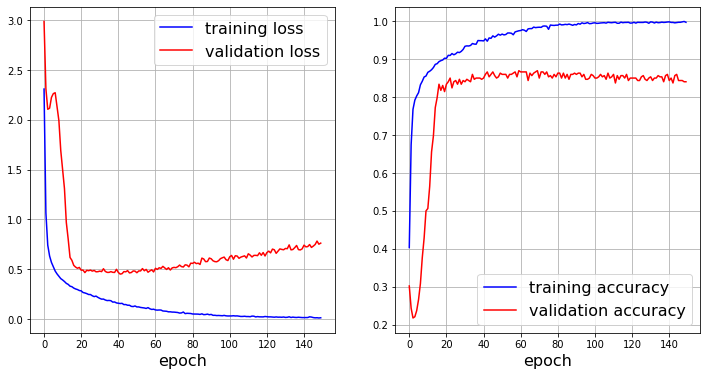

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### Test the model

In [51]:
#load the best model
best_epoch=np.argmax(acc_val_list)
best_epoch

59

In [52]:
import tensorflow
model = tensorflow.keras.models.load_model("ECG_Keras_sCE_e"+str(best_epoch)+".h5")

In [54]:
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35478711128234863
Test accuracy: 0.8855656981468201


### Make Prediction on the test set

In [55]:
Y_test_pred=model.predict(X_test, batch_size=64)

13/13 [==============================] - 0s 8ms/step


In [56]:
Y_test_pred[0]

array([1.2218069e-03, 9.9875206e-01, 4.3798145e-06, 2.1190583e-05,
       6.4288940e-07, 1.9115507e-09, 4.7243338e-09, 1.9566716e-10,
       4.8556376e-10, 2.8666116e-13, 3.0094052e-11, 1.2314961e-11,
       5.2536493e-11, 4.5253129e-10, 2.5444946e-11, 1.0303493e-12,
       6.7804290e-11, 1.3010361e-12, 1.4865364e-11, 4.8712401e-10,
       2.0643733e-09, 4.5890250e-10, 1.6170285e-10, 6.1564859e-10,
       1.1610028e-09, 9.0009472e-10, 1.1335937e-09, 5.7121413e-12,
       4.3775233e-11, 1.4343405e-11, 8.7329571e-10, 1.5385279e-09],
      dtype=float32)

In [57]:
np.argmax(Y_test_pred[0])

1

In [58]:
Y_test[0]

1

In [59]:
Y_test_pred=np.argmax(Y_test_pred, axis=1)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       176
           1       0.84      0.85      0.85       154
           2       0.92      0.91      0.92       146
           3       0.92      0.89      0.90       122
           4       0.98      0.94      0.96       171

    accuracy                           0.89       769
   macro avg       0.89      0.89      0.89       769
weighted avg       0.89      0.89      0.89       769

